# Initial Water Well exploratory

In [47]:
import matplotlib
import itertools
import numpy as np
import pandas as pd 
from numbers import Number
import sqlite3
import sqldf
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import statsmodels.api as sm
warnings.filterwarnings('ignore')

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, RocCurveDisplay
from sklearn.model_selection import cross_validate

## Import Data and Merge Datasets

In [2]:
labels_df = pd.read_csv("Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_labels.csv")

values_df = pd.read_csv("Pump_it_Up_Data_Mining_the_Water_Table_-_Training_set_values.csv")

merged_df = labels_df.merge(values_df, on='id')

test_df = pd.read_csv("Pump_it_Up_Data_Mining_the_Water_Table_-_Test_set_values.csv")

pd.set_option('display.max_columns', None)
merged_df.head()

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,functional,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,functional,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,functional,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,non functional,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,functional,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [3]:
query = """
SELECT management, COUNT(*) as count
FROM merged_df
GROUP BY management
"""

sqldf.run(query)

,management,count
0,company,685
1,other,844
2,other - school,99
3,parastatal,1768
4,private operator,1971
5,trust,78
6,unknown,561
7,vwc,40507
8,water authority,904
9,water board,2933


In [99]:
query = """
SELECT status_group, COUNT(*) as count
FROM merged_df
GROUP BY status_group
"""

sqldf.run(query)

,status_group,count
0,functional,32259
1,functional needs repair,4317
2,non functional,22824


In [100]:
#merged_df.info()
#merged_df.info()

# Some Initial Cleaning

remove a column with lots of Nulls, then drop rows with Nulls

In [5]:
merged_df_cleaning = merged_df.drop('scheme_name', axis=1)
merged_df_cleaning = merged_df_cleaning.dropna()
test_df_cleaning = test_df.drop('scheme_name', axis=1)
test_df_cleaning = test_df.dropna()
merged_df_cleaning_binary = merged_df[merged_df['status_group'] != 'functional needs repair']
merged_df_cleaning_binary.head()
#test_df_cleaning.info()

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,functional,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,1.0,GeoData Consultants Ltd,VWC,Roman,0.0,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,functional,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,None,1.0,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,functional,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,1.0,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,1.0,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,non functional,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,1.0,GeoData Consultants Ltd,VWC,None,1.0,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,functional,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,1.0,GeoData Consultants Ltd,None,None,1.0,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


# Exploratory Data Analysis

In [6]:
query = """
SELECT status_group, COUNT(*) as count
FROM merged_df_cleaning_binary
GROUP BY status_group
"""

sqldf.run(query)

,status_group,count
0,functional,32259
1,non functional,22824


In [7]:
query = """
SELECT status_group, COUNT(*) as count
FROM merged_df
GROUP BY status_group
"""

sqldf.run(query)

,status_group,count
0,functional,32259
1,functional needs repair,4317
2,non functional,22824


In [8]:
query = """
SELECT status_group, water_quality, COUNT(*) as count
FROM merged_df
GROUP BY status_group, water_quality
"""

sqldf.run(query)

,status_group,water_quality,count
0,functional,coloured,246
1,functional,fluoride,151
2,functional,fluoride abandoned,6
3,functional,milky,438
4,functional,salty,2220
5,functional,salty abandoned,174
6,functional,soft,28760
7,functional,unknown,264
8,functional needs repair,coloured,54
9,functional needs repair,fluoride,13


<Axes: xlabel='status_group', ylabel='count'>

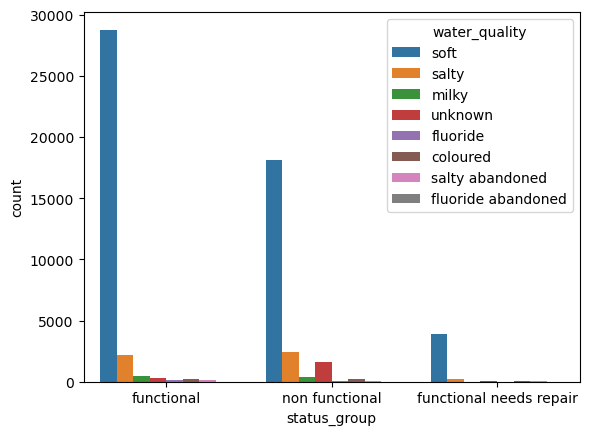

In [9]:
sns.countplot(merged_df, x="status_group", hue="water_quality")

<Axes: xlabel='water_quality', ylabel='count'>

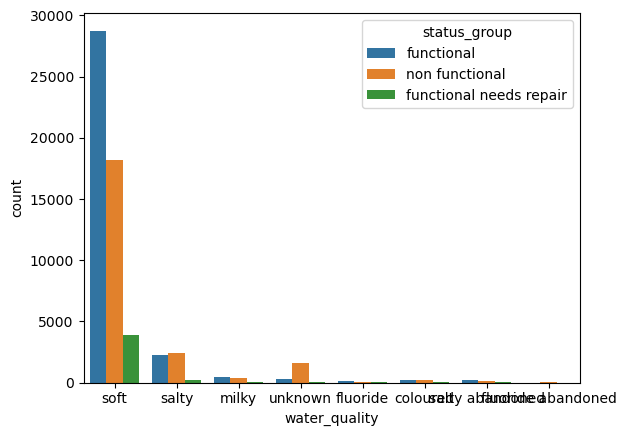

In [10]:
sns.countplot(merged_df, x="water_quality", hue="status_group")

<Axes: xlabel='status_group', ylabel='count'>

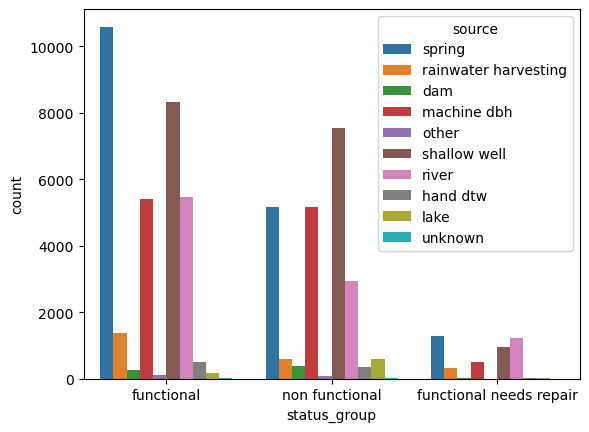

In [11]:
sns.countplot(merged_df, x="status_group", hue="source")

<Axes: xlabel='status_group', ylabel='count'>

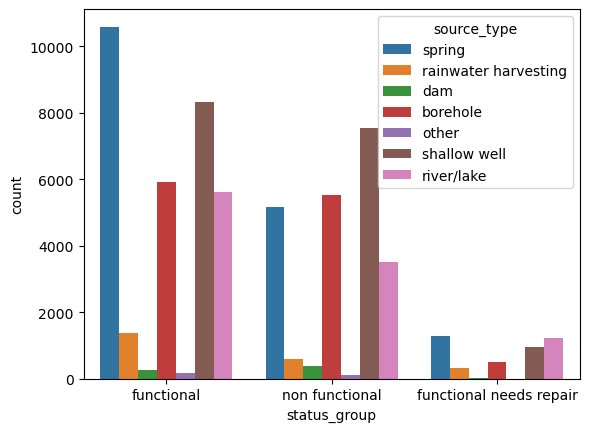

In [12]:
sns.countplot(merged_df, x="status_group", hue="source_type")

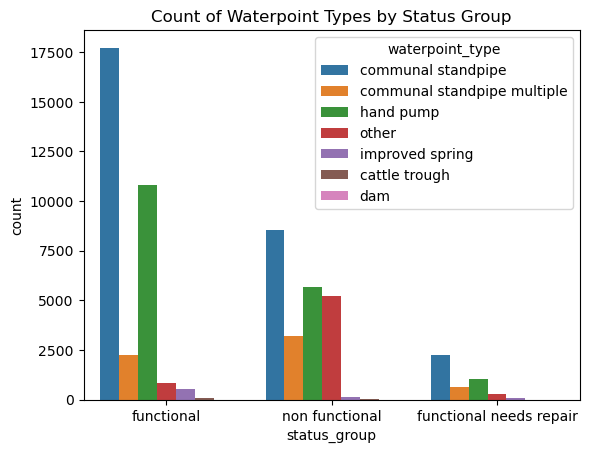

In [13]:
sns.countplot(merged_df, x="status_group", hue="waterpoint_type")
plt.title("Count of Waterpoint Types by Status Group")
plt.show()

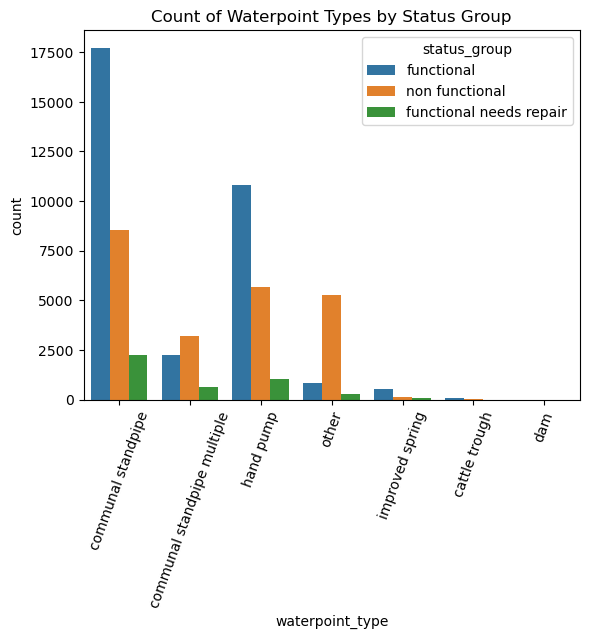

In [108]:
sns.countplot(merged_df, x="waterpoint_type", hue="status_group")
plt.title("Count of Waterpoint Types by Status Group")
plt.xticks(rotation=70)
plt.show()

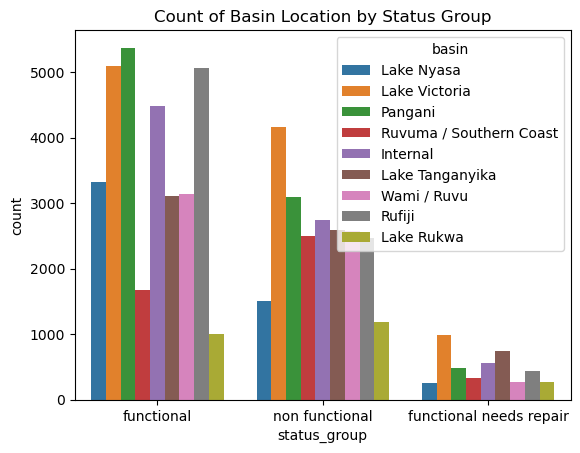

In [14]:
sns.countplot(merged_df, x="status_group", hue="basin")
plt.title("Count of Basin Location by Status Group")
plt.show()

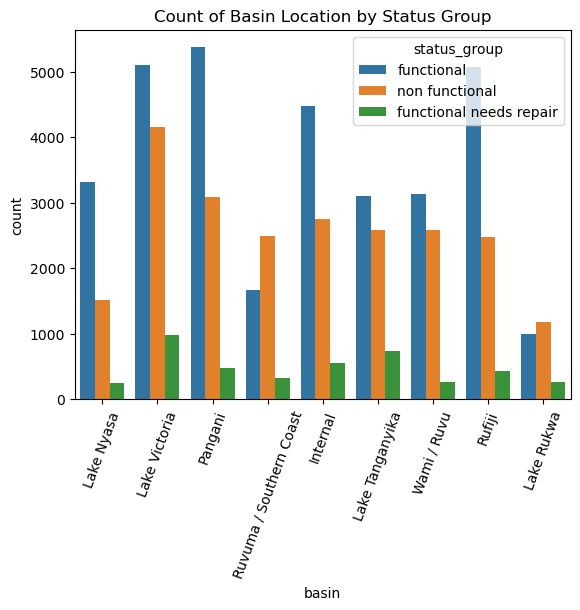

In [106]:
sns.countplot(merged_df, x="basin", hue="status_group")
plt.title("Count of Basin Location by Status Group")
plt.xticks(rotation=70)
plt.show()

 !! Basin might be useful

<Axes: xlabel='status_group', ylabel='count'>

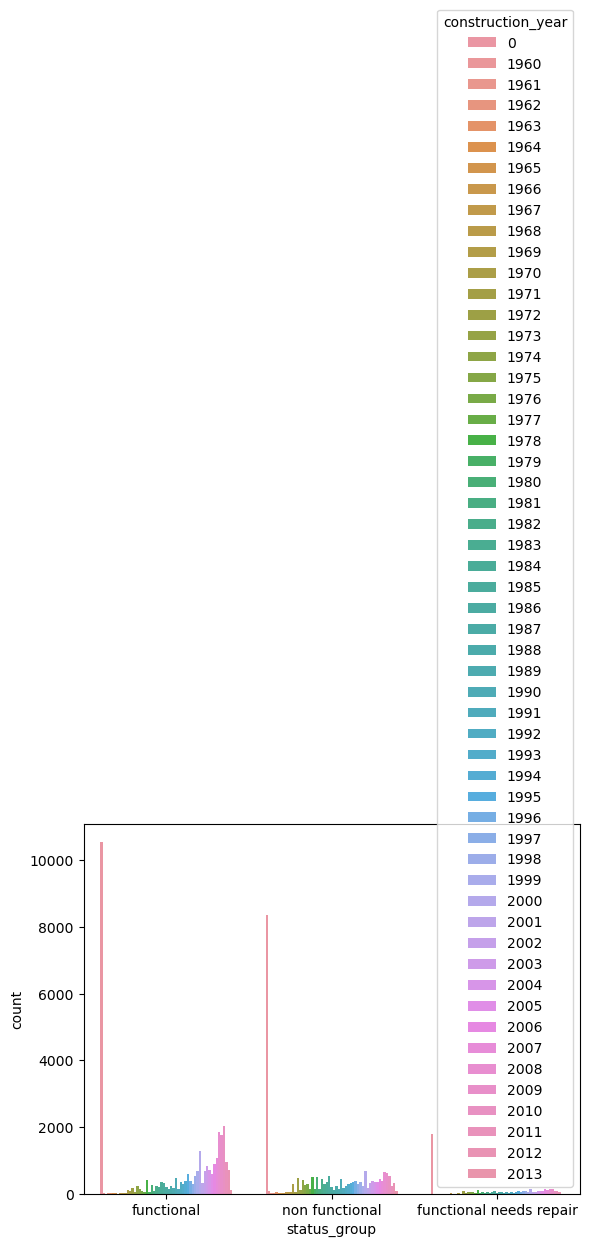

In [15]:
sns.countplot(merged_df, x="status_group", hue="construction_year")

okay, so no surprise - recently constructed wells seem more likely to be functional. This is a useful column

<Axes: xlabel='status_group', ylabel='count'>

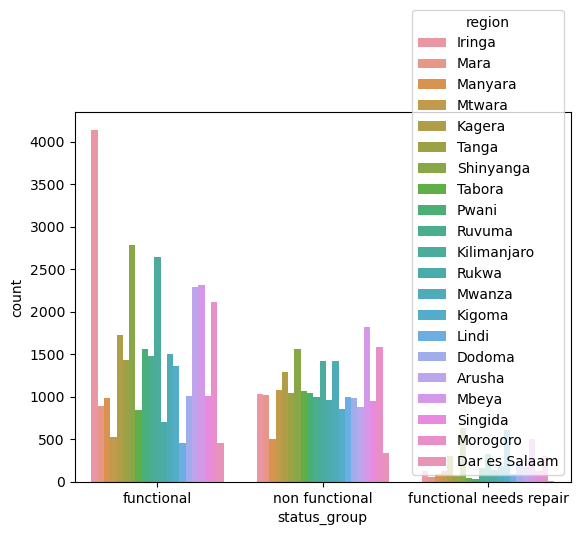

In [16]:
sns.countplot(merged_df, x="status_group", hue="region")

region could be useful

<Axes: xlabel='status_group', ylabel='count'>

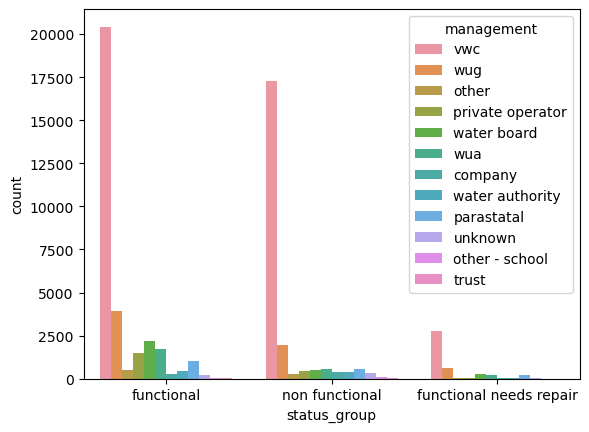

In [17]:
sns.countplot(merged_df, x="status_group", hue="management")

<Axes: xlabel='status_group', ylabel='count'>

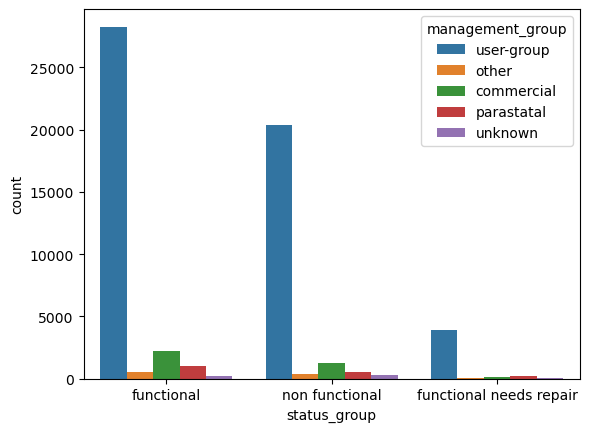

In [18]:
sns.countplot(merged_df, x="status_group", hue="management_group")

<Axes: xlabel='status_group', ylabel='count'>

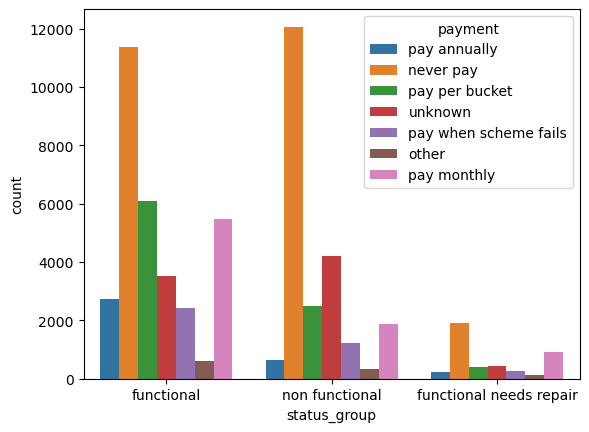

In [19]:
sns.countplot(merged_df, x="status_group", hue="payment")

<Axes: xlabel='status_group', ylabel='count'>

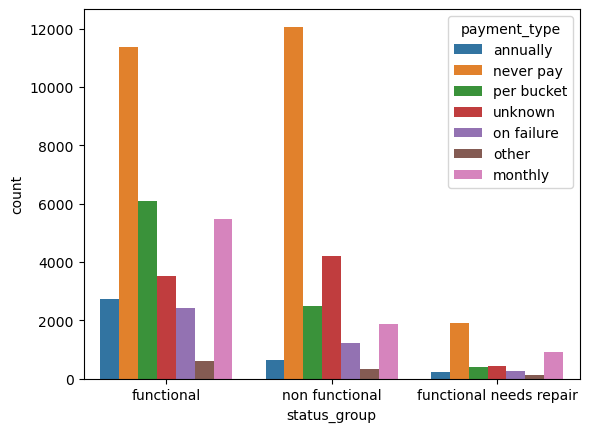

In [20]:
sns.countplot(merged_df, x="status_group", hue="payment_type")

<Axes: xlabel='status_group', ylabel='count'>

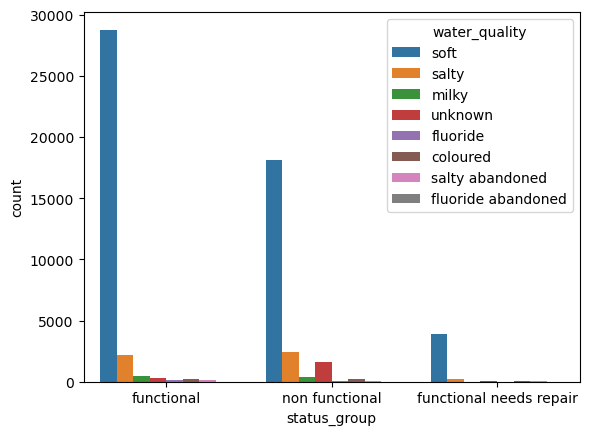

In [21]:
sns.countplot(merged_df, x="status_group", hue="water_quality")

<Axes: xlabel='status_group', ylabel='count'>

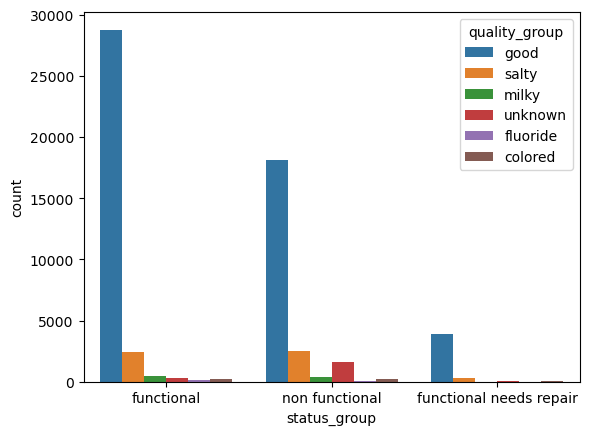

In [22]:
sns.countplot(merged_df, x="status_group", hue="quality_group")

<Axes: xlabel='status_group', ylabel='count'>

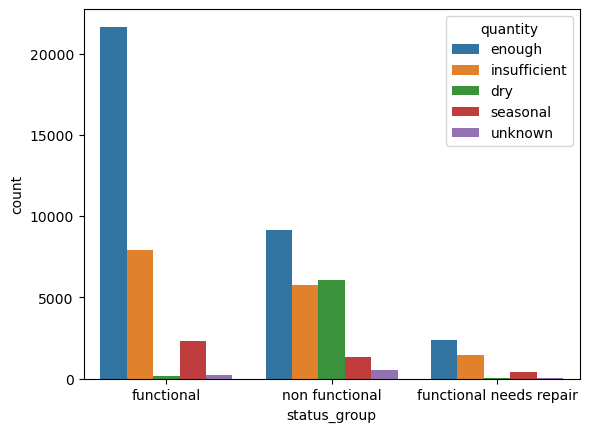

In [23]:
sns.countplot(merged_df, x="status_group", hue="quantity")

looks like there could be some useful differences here!

<Axes: xlabel='status_group', ylabel='count'>

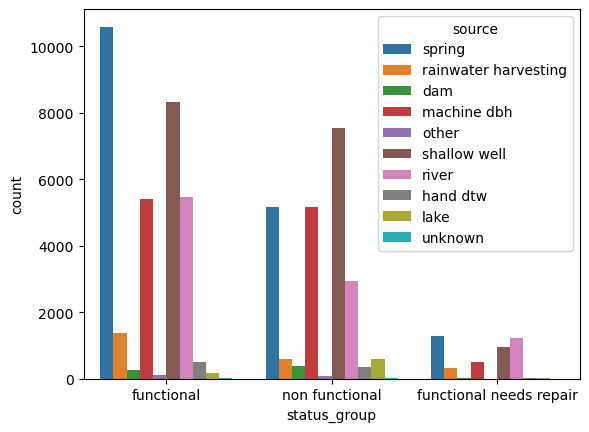

In [24]:
sns.countplot(merged_df, x="status_group", hue="source")

<Axes: xlabel='status_group', ylabel='count'>

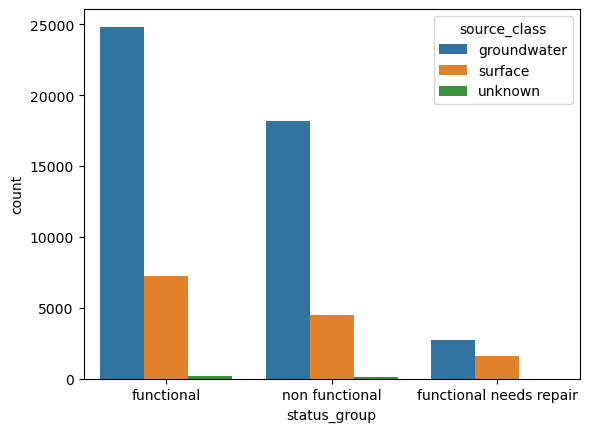

In [25]:
sns.countplot(merged_df, x="status_group", hue="source_class")

<Axes: xlabel='status_group', ylabel='count'>

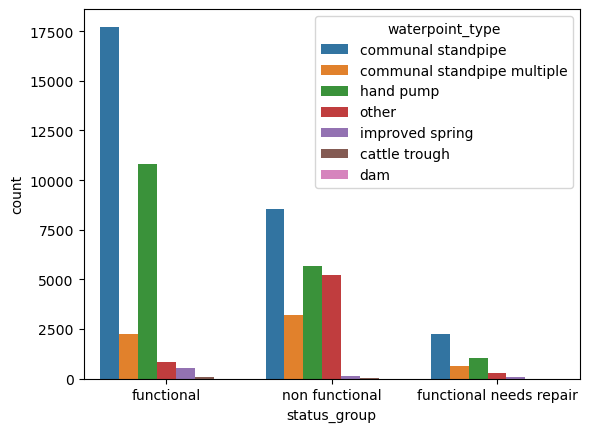

In [26]:
sns.countplot(merged_df, x="status_group", hue="waterpoint_type")

<Axes: xlabel='status_group', ylabel='count'>

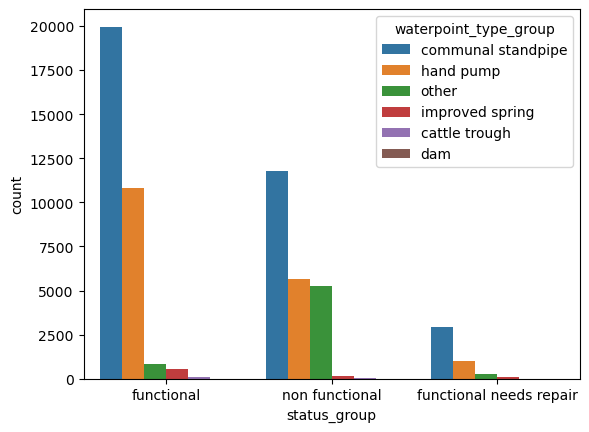

In [27]:
sns.countplot(merged_df, x="status_group", hue="waterpoint_type_group")

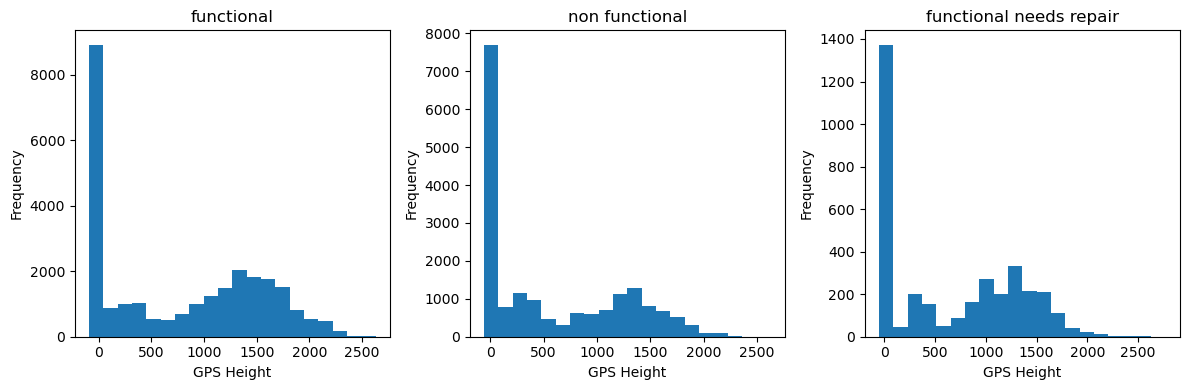

In [28]:
fig, axs = plt.subplots(1, len(merged_df_cleaning['status_group'].unique()), figsize=(12, 4))

for i, category in enumerate(merged_df_cleaning['status_group'].unique()):
    data = merged_df_cleaning[merged_df_cleaning['status_group'] == category]['gps_height']
    axs[i].hist(data, bins=20)
    axs[i].set_title(category)
    axs[i].set_xlabel('GPS Height')
    axs[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

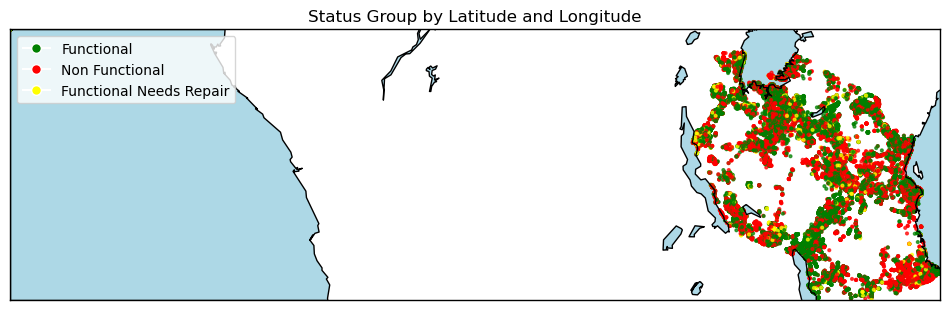

In [29]:
from mpl_toolkits.basemap import Basemap

# Create a Basemap instance
map = Basemap(llcrnrlon=merged_df_cleaning['longitude'].min(), llcrnrlat=merged_df_cleaning['latitude'].min(),
              urcrnrlon=merged_df_cleaning['longitude'].max(), urcrnrlat=merged_df_cleaning['latitude'].max(),
              projection='merc', resolution='l')

# Create a figure and axes
fig, ax = plt.subplots(figsize=(12, 8))

# Draw the map boundaries and coastlines
map.drawmapboundary(fill_color='lightblue')
map.fillcontinents(color='white', lake_color='lightblue')
map.drawcoastlines()

# Plot the data points on the map
x, y = map(merged_df_cleaning['longitude'].values, merged_df_cleaning['latitude'].values)
scatter = map.scatter(x, y, c=merged_df_cleaning['status_group'].map({'functional': 'green', 'non functional': 'red', 'functional needs repair': 'yellow'}),
                      s=4, alpha=0.7)

# Create a legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=7, label='Functional'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=7, label='Non Functional'),
                   plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='yellow', markersize=7, label='Functional Needs Repair')]
ax.legend(handles=legend_elements, loc='upper left')

# Set plot title
ax.set_title('Status Group by Latitude and Longitude')

# Show the plot
plt.show()

## Build a First Model / Baseline Model

In [30]:
# Preprocess the data
# Drop unnecessary columns
first_model_df = merged_df_cleaning[['construction_year', 'basin', 'region', 'payment', 'payment_type', 'quantity', 'waterpoint_type', 'management', 'status_group']]
# Handle missing values
first_model_df.dropna(inplace=True)
# Split the data into features (X) and target variable (y)
X = first_model_df[['construction_year', 'basin', 'region', 'payment', 'payment_type', 'quantity', 'waterpoint_type', 'management']]
y = first_model_df['status_group']

# Encode categorical variables
X_encoded = pd.get_dummies(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Create and train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7110904007455732


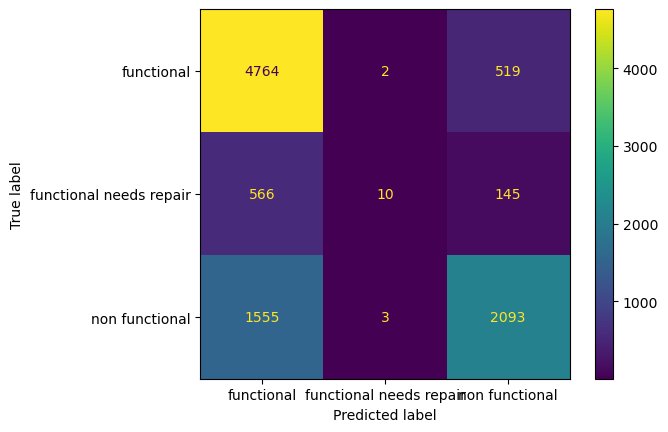

In [31]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

In [32]:
y_pred_proba = model.predict_proba(X_test)
#Compute the ROC curve for each class using the roc_curve function:
#python
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
roc_auc[i] = auc(fpr[i], tpr[i])
Plot the ROC curve for each class using RocCurveDisplay:
```python
plt.figure(figsize=(8, 6))
for i in range(numclasses):
rocdisplay = RocCurveDisplay(fpr=fpr[i], tpr=tpr[i], rocauc=rocauc[i], estimatorname=f'Class {i}')
rocdisplay.plot()
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
```

IndentationError: expected an indented block (1113365633.py, line 8)

## Switching Model to Binanry

In [33]:
# Preprocess the data
# Drop unnecessary columns
binary_model_df = merged_df_cleaning_binary[['construction_year', 'basin', 'region', 'payment', 'payment_type', 'quantity', 'waterpoint_type', 'management', 'status_group']]
# Handle missing values
binary_model_df.dropna(inplace=True)
# Split the data into features (X) and target variable (y)
X = binary_model_df[['construction_year', 'basin', 'region', 'payment', 'payment_type', 'quantity', 'waterpoint_type', 'management']]
y = binary_model_df['status_group']

# Encode categorical variables
X_encoded = pd.get_dummies(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Create and train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7721702822910048


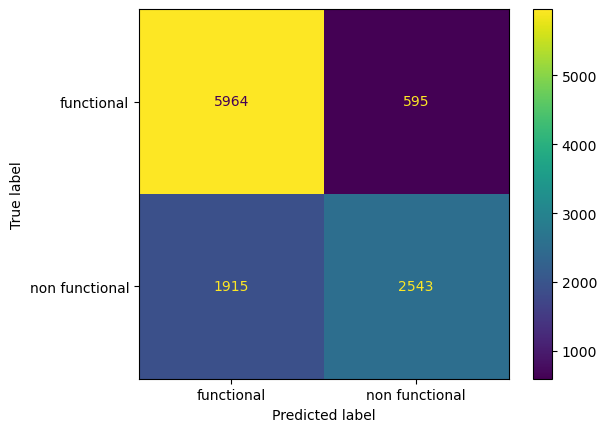

In [34]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

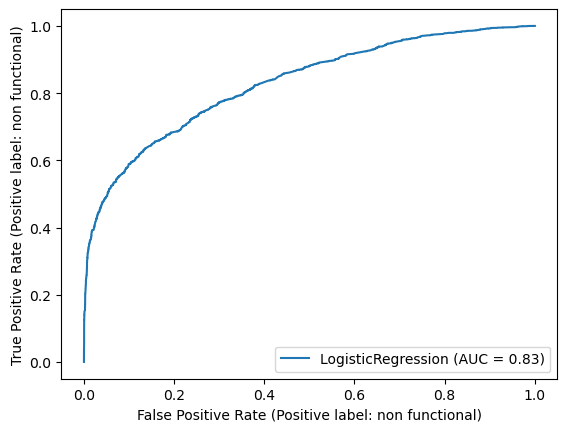

In [35]:
RocCurveDisplay.from_estimator(model, X_test, y_test)

## Eliminating Construction Year

In [36]:
# Preprocess the data
# Drop unnecessary columns
binary_model_df = merged_df_cleaning_binary[['construction_year', 'basin', 'region', 'payment', 'payment_type', 'quantity', 'waterpoint_type', 'management', 'status_group']]
# Handle missing values
binary_model_df.dropna(inplace=True)
# Split the data into features (X) and target variable (y)
X = binary_model_df[['basin', 'region', 'payment', 'payment_type', 'quantity', 'waterpoint_type', 'management']]
y = binary_model_df['status_group']

# Encode categorical variables
X_encoded = pd.get_dummies(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Create and train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7817917763456477


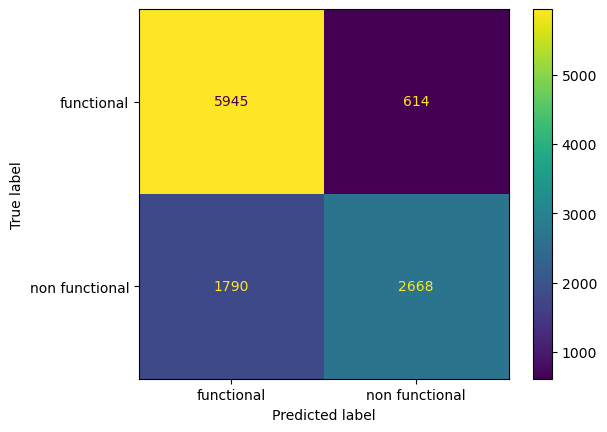

In [37]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

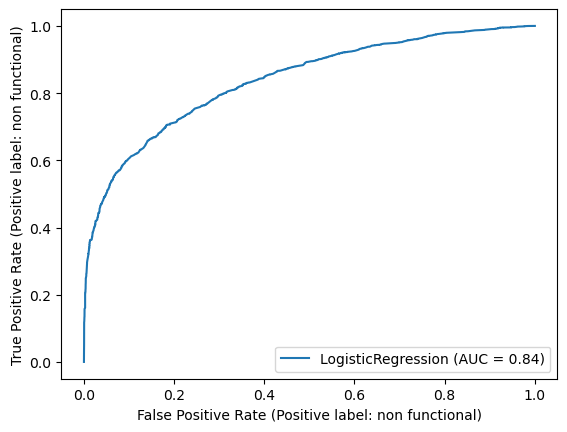

In [38]:
RocCurveDisplay.from_estimator(model, X_test, y_test)

## Adding Back In ConstYR as Years Old

In [39]:
# Preprocess the data
# Drop unnecessary columns
binary_model_df = merged_df_cleaning_binary[['construction_year', 'basin', 'region', 'payment', 'payment_type', 'quantity', 'waterpoint_type', 'management', 'status_group']]
binary_model_df['Years_Old'] = (binary_model_df['construction_year'].max() + 1) - binary_model_df['construction_year']
# Handle missing values
binary_model_df.dropna(inplace=True)
# Split the data into features (X) and target variable (y)
X = binary_model_df[['Years_Old', 'basin', 'region', 'payment', 'payment_type', 'quantity', 'waterpoint_type', 'management']]
y = binary_model_df['status_group']

# Encode categorical variables
X_encoded = pd.get_dummies(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Create and train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7590995733865844


## Scaling Data to accomodate Years Old

In [50]:
# Preprocess the data
# Drop unnecessary columns
binary_model_df = merged_df_cleaning_binary[['construction_year', 'basin', 'region', 'payment', 'payment_type', 'quantity', 'waterpoint_type', 'management', 'status_group']]
binary_model_df['Years_Old'] = (binary_model_df['construction_year'].max() + 1) - binary_model_df['construction_year']
# Handle missing values
binary_model_df.dropna(inplace=True)
# Split the data into features (X) and target variable (y)
X = binary_model_df[['Years_Old', 'basin', 'region', 'payment', 'payment_type', 'quantity', 'waterpoint_type', 'management']]
y = binary_model_df['status_group']

# Encode categorical variables
X_encoded = pd.get_dummies(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

scaler = preprocessing.MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Use transform instead of fit

# Create and train the logistic regression model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test_scaled)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7817917763456477


Same exact Acc Score as when I drop Construction entirely! Either somthing fishy is going on, or construction year is useless. But thinking about it, wouldn't construction year have at least some predictive relevance?

## Dropping Construction Year again, Toying with dropping other categories

In [93]:
# Preprocess the data
# Drop unnecessary columns
binary_model_df = merged_df_cleaning_binary[['construction_year', 'basin', 'region', 'payment', 'payment_type', 'quantity', 'waterpoint_type', 'management', 'status_group']]
# Handle missing values
binary_model_df.dropna(inplace=True)
# Split the data into features (X) and target variable (y)
X = binary_model_df[['basin', 'region', 'payment_type', 'quantity', 'waterpoint_type', 'management']]
y = binary_model_df['status_group']

# Encode categorical variables
X_encoded = pd.get_dummies(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Create and train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7817917763456477


In [94]:
model.coef_

array([[ 3.95587729e-01, -1.30329475e+00,  9.12314807e-02,
        -4.47136928e-05,  1.67477081e-01,  6.71848330e-01,
        -9.71457638e-02, -8.30704055e-02,  1.68640018e-01,
        -1.07379863e+00,  4.95867791e-01, -4.75099797e-01,
        -3.10693490e-01, -1.95084729e-01,  3.01615277e-01,
        -5.73844031e-01,  7.83467675e-01, -9.53746707e-01,
         6.64621995e-01,  7.67485376e-01,  2.84204759e-01,
         4.58708605e-01, -3.29604900e-01,  5.48973704e-01,
         8.89007616e-01,  2.80381799e-01, -6.22733492e-01,
        -5.36198457e-01,  2.28528600e-01, -6.20829954e-01,
        -5.84760977e-01, -3.82854021e-01,  5.64824399e-01,
        -4.95617207e-02,  2.87911157e-01, -3.77822132e-01,
         5.53492302e-01,  3.31404761e+00, -1.36306527e+00,
        -8.94333347e-01, -1.25446196e+00,  2.09041967e-01,
        -2.78789718e-01, -2.27360087e-01,  9.00007328e-01,
        -6.51617224e-01, -3.65787253e-01, -1.41334092e+00,
         2.04811688e+00,  1.65044979e+00, -8.82720620e-0

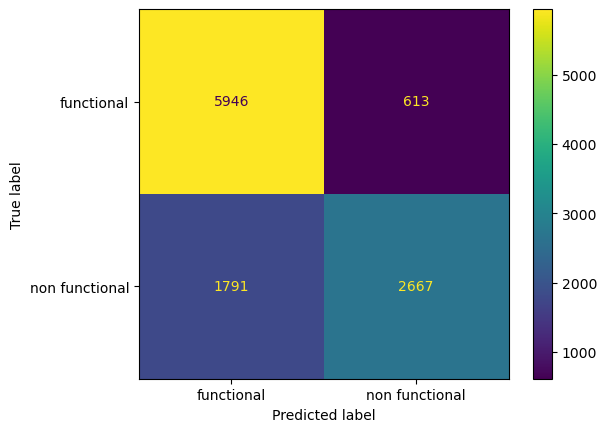

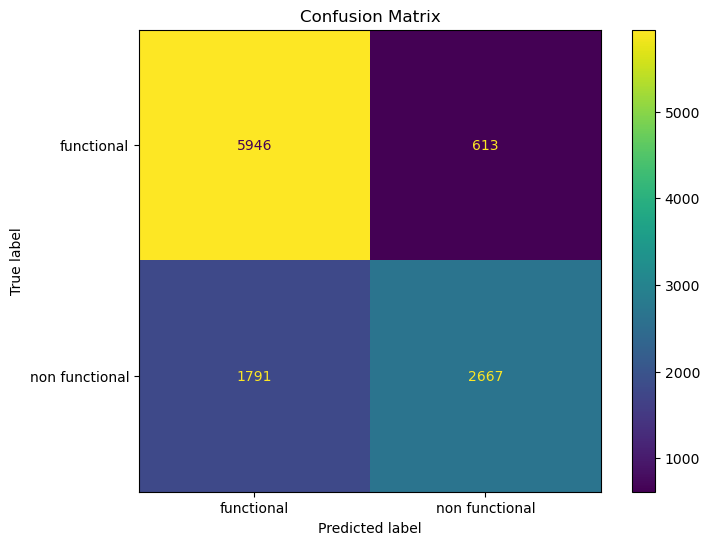

In [96]:
disp = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax)
ax.set_title("Confusion Matrix")
plt.show()

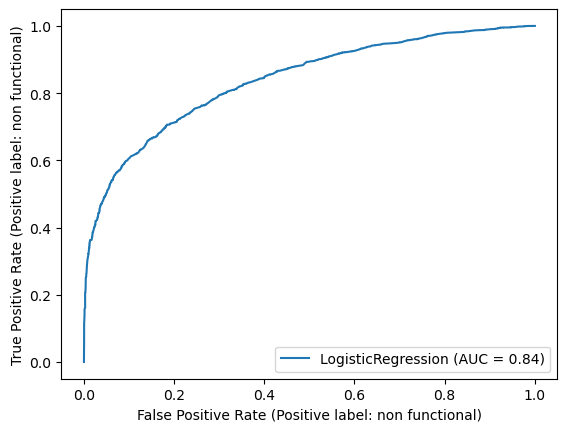

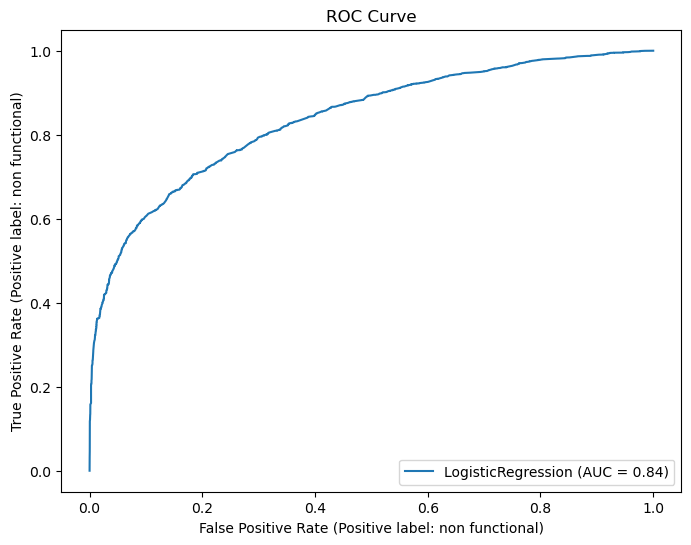

In [97]:
disp = RocCurveDisplay.from_estimator(model, X_test, y_test)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax)
ax.set_title("ROC Curve")
plt.show()

## Reverting to Scaled Model to Allow for Hyperparameterization on C

We didn't end up using this as our final model. Final Linear Regression model is the one above this

In [83]:
# Preprocess the data
# Drop unnecessary columns
binary_model_df = merged_df_cleaning_binary[['construction_year', 'basin', 'region', 'payment', 'payment_type', 'quantity', 'waterpoint_type', 'management', 'status_group']]
binary_model_df['Years_Old'] = (binary_model_df['construction_year'].max() + 1) - binary_model_df['construction_year']
# Handle missing values
binary_model_df.dropna(inplace=True)
# Split the data into features (X) and target variable (y)
X = binary_model_df[['Years_Old', 'basin', 'region', 'payment', 'payment_type', 'quantity', 'waterpoint_type', 'management']]
y = binary_model_df['status_group']

# Encode categorical variables
X_encoded = pd.get_dummies(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

scaler = preprocessing.MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Use transform instead of fit

# Create and train the logistic regression model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test_scaled)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7817917763456477


In [84]:
print(X_encoded.dtypes)

Years_Old                     int64
basin_Internal                 bool
basin_Lake Nyasa               bool
basin_Lake Rukwa               bool
basin_Lake Tanganyika          bool
                              ...  
management_vwc                 bool
management_water authority     bool
management_water board         bool
management_wua                 bool
management_wug                 bool
Length: 69, dtype: object


In [85]:
C_list = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1e3]
cv_scores = []
cv_scores_std = []

for c in C_list:
    logreg = LogisticRegression(C=c)
    cv_loop_results = cross_validate(
        estimator=logreg,
        X=X_train_scaled,
        y=y_train,
        cv=8
    )
    cv_scores.append(np.mean(cv_loop_results['test_score']))
    cv_scores_std.append(np.std(cv_loop_results['test_score']))

In [86]:
cv_scores

[0.6763263072653412,
 0.7616528016213779,
 0.7716149857043857,
 0.778286897139203,
 0.7780146813302007,
 0.7781735617678762,
 0.7783096902698206,
 0.7781962189553688]

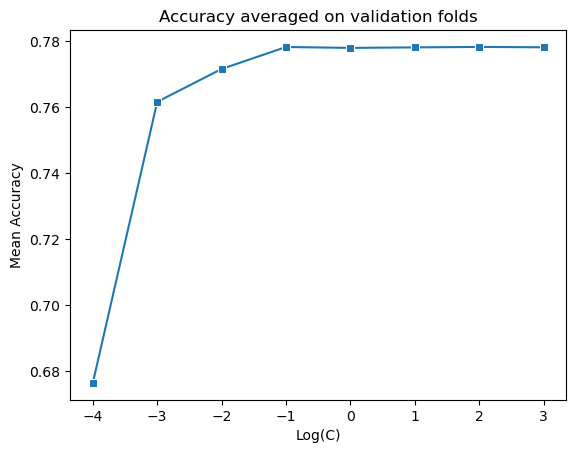

In [87]:
fig, ax = plt.subplots()
sns.lineplot(x = np.log10(C_list), y = cv_scores, marker = 's', ax = ax)
ax.set_xlabel('Log(C)')
ax.set_ylabel('Mean Accuracy')
ax.set_title('Accuracy averaged on validation folds')
plt.show()

In [88]:
# Preprocess the data
# Drop unnecessary columns
binary_model_df = merged_df_cleaning_binary[['construction_year', 'basin', 'region', 'payment', 'payment_type', 'quantity', 'waterpoint_type', 'management', 'status_group']]
binary_model_df['Years_Old'] = (binary_model_df['construction_year'].max() + 1) - binary_model_df['construction_year']
# Handle missing values
binary_model_df.dropna(inplace=True)
# Split the data into features (X) and target variable (y)
X = binary_model_df[['Years_Old', 'basin', 'region', 'payment', 'payment_type', 'quantity', 'waterpoint_type', 'management']]
y = binary_model_df['status_group']

# Encode categorical variables
X_encoded = pd.get_dummies(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

scaler = preprocessing.MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Use transform instead of fit

# Create and train the logistic regression model
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test_scaled)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7817917763456477


In [110]:
#disp = ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
#fig, ax = plt.subplots(figsize=(8, 6))
#disp.plot(ax=ax)
#ax.set_title("Confusion Matrix")
#plt.show()

In [109]:
#RocCurveDisplay.from_estimator(model, X_test, y_test)
#fig, ax = plt.subplots(figsize=(8, 6))
#disp.plot(ax=ax)
#ax.set_title("ROC Curve")
#plt.show()